In [1]:
import pickle
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

# Load pickled data
training_file = "data/train.p"
validation_file= "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

assert(len(x_train) == len(y_train))
assert(len(x_valid) == len(y_valid))
assert(len(x_test) == len(y_test))

x_train, x_test, x_valid = np.array(x_train, np.float32), np.array(x_test, np.float32), np.array(x_valid, np.float32)

In [2]:
# Number of training examples
n_train = len(x_train)

# Number of validation examples
n_validation = len(x_valid)

# Number of testing examples.
n_test = len(x_test)

# Shape of image
image_shape = x_train[0].shape

# Unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


<BarContainer object of 43 artists>

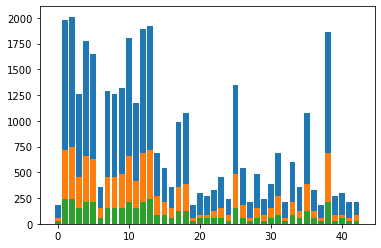

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import pandas as pd

# Visualizations will be shown in the notebook.
%matplotlib inline

# Read the CVS file with the ClassId's and the signal names
signals = pd.read_csv('signnames.csv')
# Explore the training dataset
train_values, train_counts = np.unique(y_train, return_counts = True)
plt.bar(train_values, train_counts)
# Explore the test dataset
test_values, test_counts = np.unique(y_test, return_counts = True)
plt.bar(test_values, test_counts)
# Explore the test dataset
valid_values, valid_counts = np.unique(y_valid, return_counts = True)
plt.bar(valid_values, valid_counts)

In [4]:
import tensorflow as tf

# Converting to grayscale ro reduce computation
x_train = np.sum(x_train / 3, axis = 3, keepdims = True)
x_test = np.sum(x_test / 3, axis = 3, keepdims = True)
x_valid = np.sum(x_valid / 3, axis = 3, keepdims = True)

# Maximun number of an image class
max_occurrence = np.amax(train_counts)

n_train_augmented_dataset = np.amax(train_counts) - train_counts

# Configure the image generator to create rescaled, shifted, rotated or zomm images (not flipped -> numbers and letters)
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1. / 255., 
                                                            height_shift_range = 0.1,
                                                            rotation_range = 3., 
                                                            zoom_range = [1.1,1.1])
 
for sign_class in range(n_classes):
    x = x_train[y_train == sign_class]
    while ((max_occurrence - len(x)) > 0):       
        it = train_gen.flow(x = x, y = None,
                            batch_size = (max_occurrence - len(x)),
                            shuffle = True)
        batch = it.next()
        x_train = np.concatenate((x_train, batch), axis = 0)
        y_train = np.concatenate((y_train, np.full(batch.shape[0], sign_class)))
        x = x_train[y_train == sign_class]
    
# n_train_augmented_dataset[sign_class]

In [5]:
### Preprocess the data.

def normalize(data):
    """
    Normalize the dataset (data) using the mean and the standard deviation
    
    Parameters:
        data: dataset
        
    Returns:
        
    """
    mean = np.mean(data)
    std = np.std(data)
    
    return (data - mean) / std

# Converting to grayscale
x_train = np.sum(x_train / 3, axis = 3, keepdims = True)
x_test = np.sum(x_test / 3, axis = 3, keepdims = True)
x_valid = np.sum(x_valid / 3, axis = 3, keepdims = True)

# Applying basic normalization (zero mean, standard deviation)
x_train = normalize(x_train)
x_test = normalize(x_test)
x_valid = normalize(x_valid)

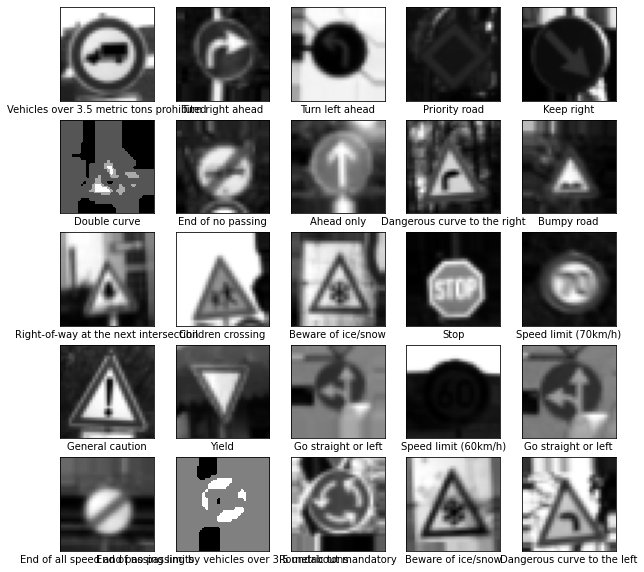

In [6]:
plt.figure(figsize=(10,10))

for step, i in enumerate(np.random.randint(0, len(x_train), size = 25)):
    plt.subplot(5, 5, step + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = 'gray')
    plt.xlabel(signals['SignName'][y_train[i]])
plt.show()

In [7]:
conv1_filters = 6
conv2_filters = 16

fc1_units = 120
fc2_units = 84

num_classes = n_classes

class ConvNet(Model):
    # Set layers.
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolution Layer with conv1_filters filters and a kernel size of 5.
        self.conv1 = layers.Conv2D(conv1_filters, kernel_size = 5, activation = tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool1 = layers.MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'VALID')

        # Convolution Layer with conv2_filters filters and a kernel size of 5.
        self.conv2 = layers.Conv2D(conv2_filters, kernel_size = 5, activation = tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool2 = layers.MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'VALID')

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(fc1_units)
        self.fc2 = layers.Dense(fc2_units)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout = layers.Dropout(rate=0.5)

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 32, 32, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training = is_training)
        x = self.fc2(x)
        x = self.dropout(x, training = is_training)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
conv_net = ConvNet()

In [12]:
# Training parameters.
learning_rate = 0.003
training_steps = 100
batch_size = 256
display_step = 10

# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.Adam(learning_rate = 0.01)

In [13]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = conv_net(x, is_training = True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = conv_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [14]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(len(x_train)).batch(batch_size).prefetch(1)

In [17]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i (batch_size: %i), loss: %f, accuracy: %f" % (step, len(batch_x), loss, acc))

step: 10 (batch_size: 256), loss: 3.484998, accuracy: 0.351562
step: 20 (batch_size: 256), loss: 3.494463, accuracy: 0.324219
step: 30 (batch_size: 256), loss: 3.500466, accuracy: 0.332031
step: 40 (batch_size: 256), loss: 3.460218, accuracy: 0.367188
step: 50 (batch_size: 256), loss: 3.435401, accuracy: 0.433594
step: 60 (batch_size: 256), loss: 3.421290, accuracy: 0.429688
step: 70 (batch_size: 256), loss: 3.470159, accuracy: 0.406250
step: 80 (batch_size: 256), loss: 3.460507, accuracy: 0.375000
step: 90 (batch_size: 256), loss: 3.401123, accuracy: 0.457031
step: 100 (batch_size: 256), loss: 3.371715, accuracy: 0.472656


In [ ]:
conv_net.summary()